# ***Big Data Science operations and Machine Learning on Diamonds price prediction Using advanced python APIs***

In [2]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=98199abed7c08cac013f1d22de8ce82b6c25180234bdf1aac2270a439a9cf631
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("DiamondAnalysis")\
                  .set("spark.driver.memory", "16g")\
                  .set("spark.executor.memory", "16g")

# Create a Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
diamonds_df = spark.read.csv("/content/sample_data/diamonds.csv", header=True, inferSchema=True)
diamonds_df.show()

+---+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|_c0|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+---+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|  1| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
|  2| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
|  3| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
|  4| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
|  5| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
|  6| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
|  7| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
|  8| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
|  9| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 10| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
| 11|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 12| 0.23|    Ideal|    J|    VS1

In [4]:
import pandas as pd
pd.DataFrame(diamonds_df.take(5), columns=diamonds_df.columns)

,_c0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
diamonds_df.select('price').describe().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            53940|
|   mean|3932.799721913237|
| stddev|3989.439738146397|
|    min|              326|
|    max|            18823|
+-------+-----------------+



In [6]:
# Count rows before dropping null values
before_count = diamonds_df.count()

# Drop null values in each specified column
diamonds_df = diamonds_df.dropna(how="any", subset=["carat", "cut", "color", "clarity", "depth", "table", "price", "x", "y", "z"])

after_count = diamonds_df.count()
print(f"Before dropping null values: {before_count}")
print(f"After dropping null values: {after_count}")


Before dropping null values: 53940
After dropping null values: 53940


In [7]:
diamonds_df = diamonds_df.na.drop(subset=["carat", "cut", "color", "clarity", "depth", "table", "price", "x", "y", "z"])

In [8]:
from pyspark.ml.feature import StringIndexer

indexer_cut = StringIndexer(inputCol="cut", outputCol="cut_index")
indexer_color = StringIndexer(inputCol="color", outputCol="color_index")
indexer_clarity = StringIndexer(inputCol="clarity", outputCol="clarity_index")

diamonds_df = indexer_cut.fit(diamonds_df).transform(diamonds_df)
diamonds_df = indexer_color.fit(diamonds_df).transform(diamonds_df)
diamonds_df = indexer_clarity.fit(diamonds_df).transform(diamonds_df)

In [9]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['carat', 'cut_index', 'color_index', 'clarity_index', 'depth', 'table'],
                            outputCol='features')
data = assembler.transform(diamonds_df).select('features', 'price')

In [10]:
diamonds_df.select('carat', 'cut_index', 'color_index', 'clarity_index', 'depth', 'table').show()

+-----+---------+-----------+-------------+-----+-----+
|carat|cut_index|color_index|clarity_index|depth|table|
+-----+---------+-----------+-------------+-----+-----+
| 0.23|      0.0|        1.0|          2.0| 61.5| 55.0|
| 0.21|      1.0|        1.0|          0.0| 59.8| 61.0|
| 0.23|      3.0|        1.0|          3.0| 56.9| 65.0|
| 0.29|      1.0|        5.0|          1.0| 62.4| 58.0|
| 0.31|      3.0|        6.0|          2.0| 63.3| 58.0|
| 0.24|      2.0|        6.0|          4.0| 62.8| 57.0|
| 0.24|      2.0|        5.0|          5.0| 62.3| 57.0|
| 0.26|      2.0|        3.0|          0.0| 61.9| 55.0|
| 0.22|      4.0|        1.0|          1.0| 65.1| 61.0|
| 0.23|      2.0|        3.0|          3.0| 59.4| 61.0|
|  0.3|      3.0|        6.0|          0.0| 64.0| 55.0|
| 0.23|      0.0|        6.0|          3.0| 62.8| 56.0|
| 0.22|      1.0|        2.0|          0.0| 60.4| 61.0|
| 0.31|      0.0|        6.0|          2.0| 62.2| 54.0|
|  0.2|      1.0|        1.0|          2.0| 60.2

In [11]:
diamonds_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- cut_index: double (nullable = false)
 |-- color_index: double (nullable = false)
 |-- clarity_index: double (nullable = false)



In [12]:
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

In [13]:
train_data.printSchema()
test_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- price: integer (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- price: integer (nullable = true)



In [14]:
train_count = train_data.count()
test_count = test_data.count()
print(f"Training Data Count: {train_count}")
print(f"Testing Data Count: {test_count}")

Training Data Count: 37764
Testing Data Count: 16176


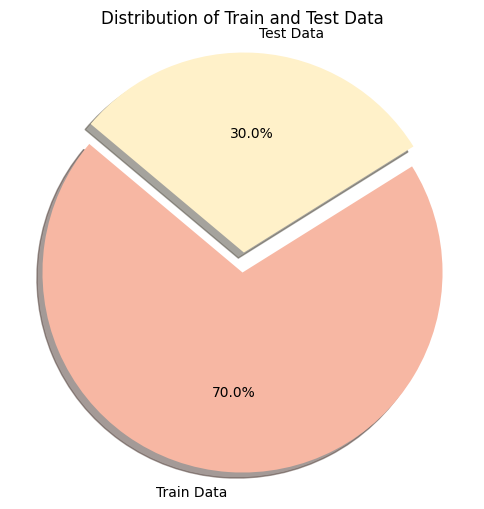

In [15]:
import matplotlib.pyplot as plt

labels = ['Train Data', 'Test Data']
sizes = [train_data.count(), test_data.count()]
explode = (0.1, 0)

colors = ['#F7B7A3', '#FFF1C9']

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140, colors=colors)
plt.axis('equal')
plt.title('Distribution of Train and Test Data')
plt.show()

In [16]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


lr_model = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr_model.fit(train_data)
predictions_lr = lr_model.transform(test_data)


lr_evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="price", predictionCol="prediction")
lr_evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="price", predictionCol="prediction")

rmse = lr_evaluator_rmse.evaluate(predictions_lr)
r2 = lr_evaluator_r2.evaluate(predictions_lr)

predictions_lr.select("price", "prediction").show(5)
print(f"Linear regresser RMSE: {rmse}")
print(f"Linear regresser R2: {r2}")


+-----+-------------------+
|price|         prediction|
+-----+-------------------+
|  367|-1056.8958758651252|
|  367| -752.1789920813835|
|  367|-1068.8489299126559|
|  367|-1398.5995002477748|
|  386| -388.6506875637706|
+-----+-------------------+
only showing top 5 rows

Linear regresser RMSE: 1463.0917663373814
Linear regresser R2: 0.866432759684018


In [17]:
from pyspark.ml.regression import DecisionTreeRegressor

dt_model_tuned = DecisionTreeRegressor(featuresCol="features", labelCol="price", maxDepth=15, maxBins=10564)

dt_model_tuned = dt_model_tuned.fit(train_data)
predictions_dt = dt_model_tuned.transform(test_data)

dt_evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="price", predictionCol="prediction")
dt_evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="price", predictionCol="prediction")

rmse_dt = dt_evaluator_rmse.evaluate(predictions_dt)
r2_dt = dt_evaluator_r2.evaluate(predictions_dt)

predictions_dt.select("price", "prediction").show(5)
print(f"Decision Tree RMSE: {rmse_dt}")
print(f"Decision Tree R2: {r2_dt}")

+-----+----------+
|price|prediction|
+-----+----------+
|  367|     367.0|
|  367|     367.0|
|  367|     367.0|
|  367|     367.0|
|  386|     386.0|
+-----+----------+
only showing top 5 rows

Decision Tree RMSE: 684.8220095544284
Decision Tree R2: 0.9707374452141118


In [18]:
from pyspark.ml.regression import GBTRegressor

gbt_model = GBTRegressor(featuresCol="features", labelCol="price")

# Set hyperparameters
gbt_model.setMaxDepth(10)
gbt_model.setMaxIter(5)
gbt_model.setStepSize(0.4)

gbt_model = gbt_model.fit(train_data)
predictions_gbt = gbt_model.transform(test_data)

gbt_evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="price", predictionCol="prediction")
gbt_evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="price", predictionCol="prediction")

rmse = gbt_evaluator_rmse.evaluate(predictions_gbt)
r2 = gbt_evaluator_r2.evaluate(predictions_gbt)

predictions_gbt.select("price", "prediction").show(5)
print(f"Gradiebt boost tree RMSE: {rmse}")
print(f"Gradiebt boost tree R2: {r2}")

+-----+------------------+
|price|        prediction|
+-----+------------------+
|  367|471.41717705311083|
|  367| 493.9367183843891|
|  367| 509.7768185388667|
|  367| 510.8332182165782|
|  386| 557.1512646221835|
+-----+------------------+
only showing top 5 rows

Gradiebt boost tree RMSE: 731.6276166558678
Gradiebt boost tree R2: 0.9666007279651433


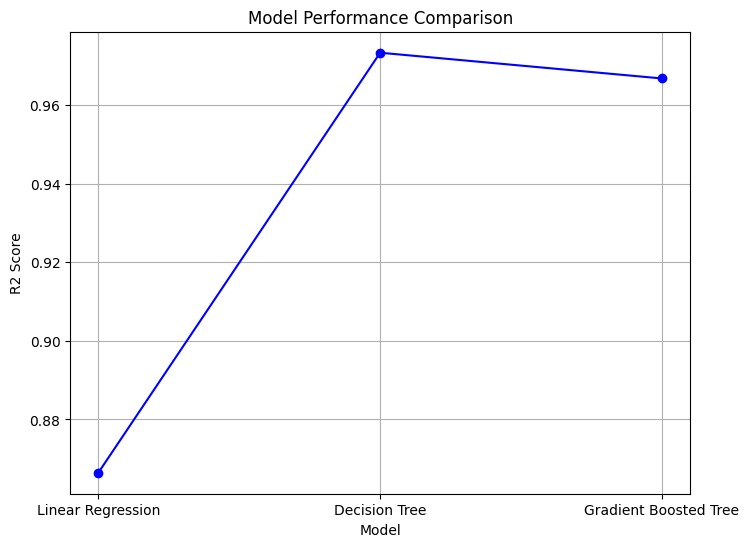

In [ ]:
import matplotlib.pyplot as plt

r2_scores = [lr_evaluator_r2.evaluate(predictions_lr),
             dt_evaluator_r2.evaluate(predictions_dt),
             gbt_evaluator_r2.evaluate(predictions_gbt)]

models = ['Linear Regression', 'Decision Tree', 'Gradient Boosted Tree']

plt.figure(figsize=(8, 6))
plt.plot(models, r2_scores, marker='o', color='b')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

In [ ]:
diamonds_df.select('carat', 'cut_index', 'color_index', 'clarity_index', 'depth', 'table').show()

+-----+---------+-----------+-------------+-----+-----+
|carat|cut_index|color_index|clarity_index|depth|table|
+-----+---------+-----------+-------------+-----+-----+
| 0.23|      0.0|        1.0|          2.0| 61.5| 55.0|
| 0.21|      1.0|        1.0|          0.0| 59.8| 61.0|
| 0.23|      3.0|        1.0|          3.0| 56.9| 65.0|
| 0.29|      1.0|        5.0|          1.0| 62.4| 58.0|
| 0.31|      3.0|        6.0|          2.0| 63.3| 58.0|
| 0.24|      2.0|        6.0|          4.0| 62.8| 57.0|
| 0.24|      2.0|        5.0|          5.0| 62.3| 57.0|
| 0.26|      2.0|        3.0|          0.0| 61.9| 55.0|
| 0.22|      4.0|        1.0|          1.0| 65.1| 61.0|
| 0.23|      2.0|        3.0|          3.0| 59.4| 61.0|
|  0.3|      3.0|        6.0|          0.0| 64.0| 55.0|
| 0.23|      0.0|        6.0|          3.0| 62.8| 56.0|
| 0.22|      1.0|        2.0|          0.0| 60.4| 61.0|
| 0.31|      0.0|        6.0|          2.0| 62.2| 54.0|
|  0.2|      1.0|        1.0|          2.0| 60.2

In [31]:
import ipywidgets as widgets
from ipywidgets import IntSlider, Dropdown, FloatSlider, Button, VBox

carat_slider = FloatSlider(min=0.2, max=5.0, value=1.0, step=0.1, description='Carat:')
cut_dropdown = Dropdown(options=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], value='Ideal', description='Cut:')
color_dropdown = Dropdown(options=['D', 'E', 'F', 'G', 'H', 'I', 'J'], value='G', description='Color:')
clarity_dropdown = Dropdown(options=['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], value='SI1', description='Clarity:')
depth_slider = FloatSlider(min=43.0, max=79.0, value=61.8, step=0.1, description='Depth:')
table_slider = FloatSlider(min=43.0, max=95.0, value=57.0, step=0.1, description='Table:')

predict_button = Button(description="Predict")

def predict_price(button):
  carat = carat_slider.value
  cut = cut_dropdown.value
  color = color_dropdown.value
  clarity = clarity_dropdown.value
  depth = depth_slider.value
  table = table_slider.value

  indexer_cut = StringIndexer(inputCol="cut", outputCol="cut_index_new")
  indexer_color = StringIndexer(inputCol="color", outputCol="color_index_new")
  indexer_clarity = StringIndexer(inputCol="clarity", outputCol="clarity_index_new")

  indexer_cut_model = indexer_cut.fit(diamonds_df)
  indexer_color_model = indexer_color.fit(diamonds_df)
  indexer_clarity_model = indexer_clarity.fit(diamonds_df)

  transformed_data = indexer_cut_model.transform(diamonds_df)
  transformed_data = indexer_color_model.transform(diamonds_df)
  transformed_data = indexer_clarity_model.transform(diamonds_df)

  cut_index = transformed_data.select("cut_index").head()[0]
  color_index = transformed_data.select("color_index").head()[0]
  clarity_index = transformed_data.select("clarity_index").head()[0]

  features = [carat, cut_index, color_index, clarity_index, depth, table]
  from pyspark.ml.linalg import Vectors
  features_vector = Vectors.dense(features)

  prediction = dt_model_tuned.predict(features_vector)
  print(f"Predicted price: ${prediction:.2f}")

predict_button.on_click(predict_price)
VBox([carat_slider, cut_dropdown, color_dropdown, clarity_dropdown, depth_slider, table_slider, predict_button])

Predicted price: $326.00


In [26]:
pd.DataFrame(diamonds_df.take(10), columns=diamonds_df.columns)

,_c0,carat,cut,color,clarity,depth,table,price,x,y,z,cut_index,color_index,clarity_index
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0.0,1.0,2.0
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,1.0,1.0,0.0
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,3.0,1.0,3.0
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,1.0,5.0,1.0
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,3.0,6.0,2.0
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,2.0,6.0,4.0
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,2.0,5.0,5.0
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,2.0,3.0,0.0
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,4.0,1.0,1.0
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,2.0,3.0,3.0


In [ ]:
diamonds_df = pd.read_csv('/content/sample_data/diamonds.csv')
diamonds_df.nunique()

Unnamed: 0    53940
carat           273
cut               5
color             7
clarity           8
depth           184
table           127
price         11602
x               554
y               552
z               375
dtype: int64

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'price vs carat')

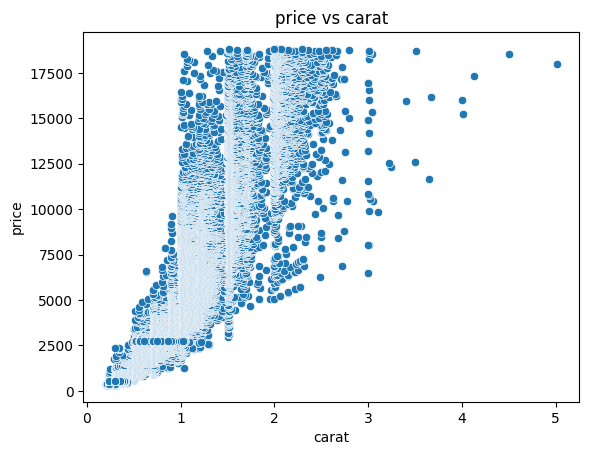

In [ ]:
sns.scatterplot(x = 'carat', y='price', data=diamonds_df)
plt.title('price vs carat')

<ipython-input-59-3d99626653b7>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'clarity', y = 'price', data = diamonds_df, palette = 'Set2')


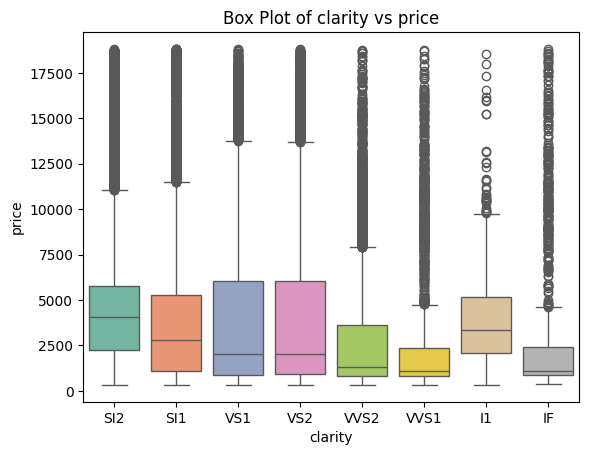

In [ ]:
sns.boxplot(x = 'clarity', y = 'price', data = diamonds_df, palette = 'Set2')
plt.title('Box Plot of clarity vs price')
plt.show()

<ipython-input-60-eb75c6fab60d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'color', y = 'price', data = diamonds_df, palette = 'Set2')


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'E'),
  Text(1, 0, 'I'),
  Text(2, 0, 'J'),
  Text(3, 0, 'H'),
  Text(4, 0, 'F'),
  Text(5, 0, 'G'),
  Text(6, 0, 'D')])

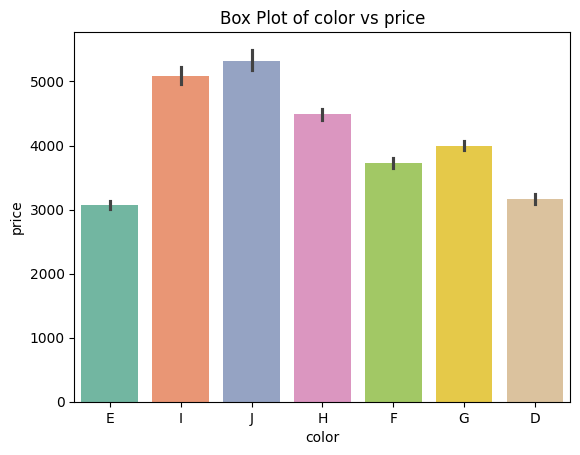

In [ ]:
sns.barplot(x = 'color', y = 'price', data = diamonds_df, palette = 'Set2')
plt.title('Box Plot of color vs price')
plt.xticks(rotation = 360)

In [ ]:
diamonds_df['cut'] = diamonds_df['cut'].astype('category').cat.codes
diamonds_df['color'] = diamonds_df['color'].astype('category').cat.codes
diamonds_df['clarity'] = diamonds_df['clarity'].astype('category').cat.codes

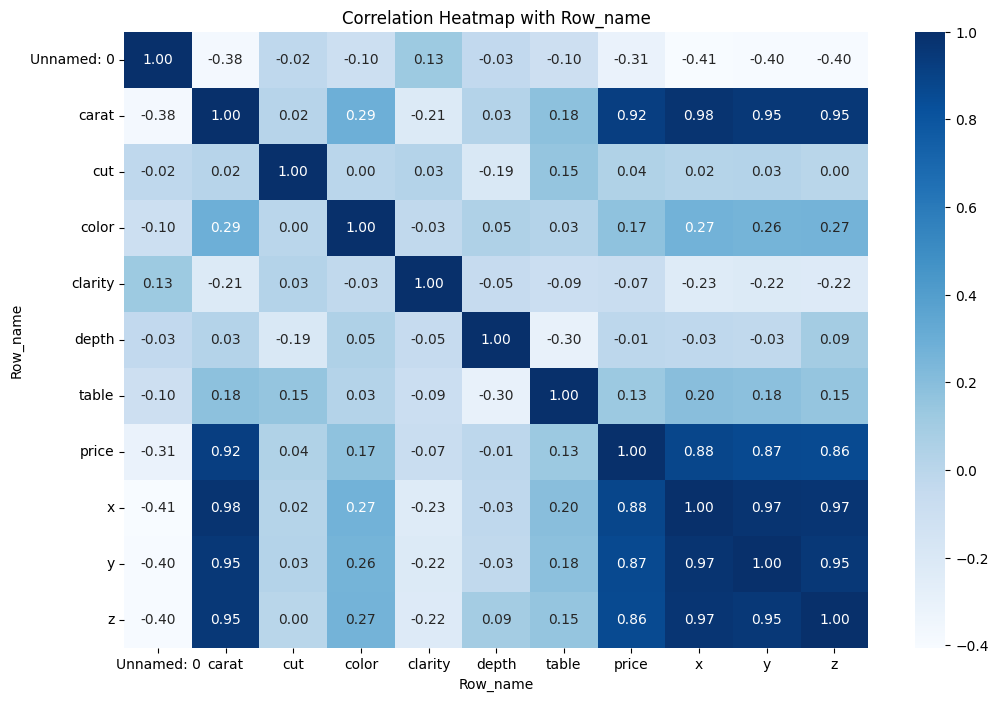

In [ ]:
corr = diamonds_df.corr()

corr_with_names = pd.DataFrame(corr.values, columns=diamonds_df.columns, index=diamonds_df.columns)
corr_with_names.index.name = "Row_name"

plt.figure(figsize=(12, 8))
sns.heatmap(corr_with_names, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap with Row_name")
plt.show()

In [ ]:
carat = float(input("Enter carat: "))
cut = input("Enter cut (Fair, Good, Very Good, Premium, Ideal): ")
color = input("Enter color (D, E, F, G, H, I, J): ")
clarity = input("Enter clarity (I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF): ")
depth = float(input("Enter depth: "))
table = float(input("Enter table: "))

indexer_cut = StringIndexer(inputCol="cut", outputCol="cut_index_new")
indexer_color = StringIndexer(inputCol="color", outputCol="color_index_new")
indexer_clarity = StringIndexer(inputCol="clarity", outputCol="clarity_index_new")

indexer_cut_model = indexer_cut.fit(diamonds_df)
indexer_color_model = indexer_color.fit(diamonds_df)
indexer_clarity_model = indexer_clarity.fit(diamonds_df)

transformed_data = indexer_cut_model.transform(diamonds_df)
transformed_data = indexer_color_model.transform(diamonds_df)
transformed_data = indexer_clarity_model.transform(diamonds_df)

cut_index = transformed_data.select("cut_index").head()[0]
color_index = transformed_data.select("color_index").head()[0]
clarity_index = transformed_data.select("clarity_index").head()[0]

features = [carat, cut_index, color_index, clarity_index, depth, table]
from pyspark.ml.linalg import Vectors
features_vector = Vectors.dense(features)

prediction = dt_model_tuned.predict(features_vector)

print(f"Predicted price: ${prediction:.2f}")